## FFT, Spectrogram Interpretation and hyper-prarameter Tuning
Submitted by Rohit Lal

In [1]:
import torchaudio
import torch
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # can be accelerated changed to GPU 
device

device(type='cpu')

## Loading and preprocessing
- Load the audio 
- Crop the audio
- Convert Stereo to mono audio

In [2]:
# Load an audio file. Returns a tensor and the sampling rate.
audio_path = 'Audio_Glasslink.mp3'
waveform_s, new_freq = torchaudio.load(audio_path) # Sample first n frames
print(f'Audio has {waveform_s.shape[1]} frames. Sample rate: {new_freq}, Total_time = {waveform_s.shape[1]/new_freq} sec')

Audio has 31230720 frames. Sample rate: 44100, Total_time = 708.1795918367347 sec


In [3]:
n_frames = 500000
resamp_crop = waveform_s[:,:n_frames]
print(f'Audio has {resamp_crop.shape[1]} frames. Sample rate: {new_freq}, Total_time = {resamp_crop.shape[1]/new_freq} sec')

Audio has 500000 frames. Sample rate: 44100, Total_time = 11.337868480725623 sec


In [4]:
waveform = resamp_crop.mean(0) # Converting stereo to mono audio by averaging

## Reasoning Behind Parameter Choices:

- For music or speech, where capturing the harmonic structure is important, a larger n_fft may be chosen.
- For transient sounds or rapidly changing signals, a smaller hop_length may be preferable to capture the temporal variations more accurately.
- For real-time systems, the computational load is also a consideration. Higher n_fft and lower hop_length increase computational complexity, so a balance must be found that suits the hardware capabilities.

After doing a small grid search (experiments later in notebook) we found out that the best window_size = 4096, hop_length = 4 

For code testing, we increase hop length to improve computational speed. 

In [8]:
window_size = 2048
hop_length = 512

# Ensure waveform is on GPU/CPU
waveform = waveform.to(device)

# Number of frames
num_frames = 1 + (len(waveform) - window_size) // hop_length

# Pre-allocate a tensor to hold the FFT results
fft_results = torch.zeros((num_frames, window_size // 2 + 1), device=device, dtype=torch.complex64)

# Apply windowing and FFT
for i in range(num_frames):
    start = i * hop_length
    end = start + window_size
    frame = waveform[start:end] * torch.hann_window(window_size, device=device)
    fft_result = torch.fft.fft(frame)[:window_size // 2 + 1]  # Take half, since it's symmetric
    fft_results[i] = fft_result

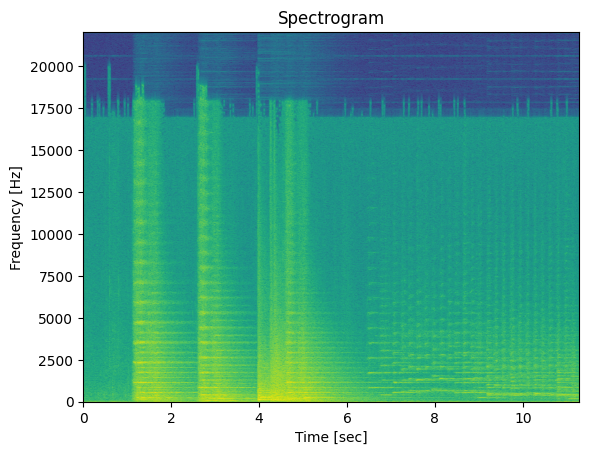

In [6]:
# Convert FFT results to magnitude (absolute value of complex numbers)
fft_magnitude = torch.abs(fft_results).cpu().numpy()

# Generating the time axis
time_steps = np.arange(num_frames) * hop_length / new_freq

# Generating the frequency axis
frequencies = np.linspace(0, new_freq / 2, window_size // 2 + 1)

# Plotting the spectrogram
# plt.figure(figsize=(10, 6))
plt.pcolormesh(time_steps, frequencies, np.log(fft_magnitude.T + 1e-9), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.show()

## Spectrogram Analysis:
After visualising the above spectrogram we make following observations

- **Digital Silence or Noise Floor**: The very top of the spectrogram shows a dark region which could be indicative of the limit of the recording equipment's frequency response, digital silence, or a noise floor that is not part of the music. The spectrogram shows energy extending across a wide frequency range, up to the limit of human hearing (around 20 kHz).

- **Energy Concentration in Lower Frequencies**: There is a significant concentration of energy in the lower frequencies, which is typical for orchestral music as it contains a variety of lower-pitched instruments like cellos, double basses, bassoons, and timpani that have strong fundamentals in this range.

- **Harmonic Structures**: The presence of multiple horizontal lines, especially visible in the lower to mid-frequency range, indicates harmonic structures. These are likely the fundamental frequencies of musical notes being played along with their harmonics, which are integer multiples of these fundamental frequencies.

- **Transient Details**: The vertical lines, particularly visible in the lower frequencies at various time intervals, represent transient events such as percussive sounds or sharp attacks from instruments like the piano or staccato strings. In the context of a symphony, these could correspond to rhythmic motifs or accents in the score.

- **High-Frequency Content**: There's a consistent presence of high-frequency content above 10 kHz, which often comes from the overtones of musical instruments and the sibilance or high-pitched consonants from the choir, if vocal elements are present. The high-frequency roll-off is also gradual, indicating a high-quality recording with a wide frequency response.

- **Dynamic Range**: The spectrogram shows a wide dynamic range, evidenced by the varying intensity of colors from dark blue to bright yellow. This wide dynamic range is typical for classical music, especially symphonies, which are known for their varying dynamics and expressiveness.

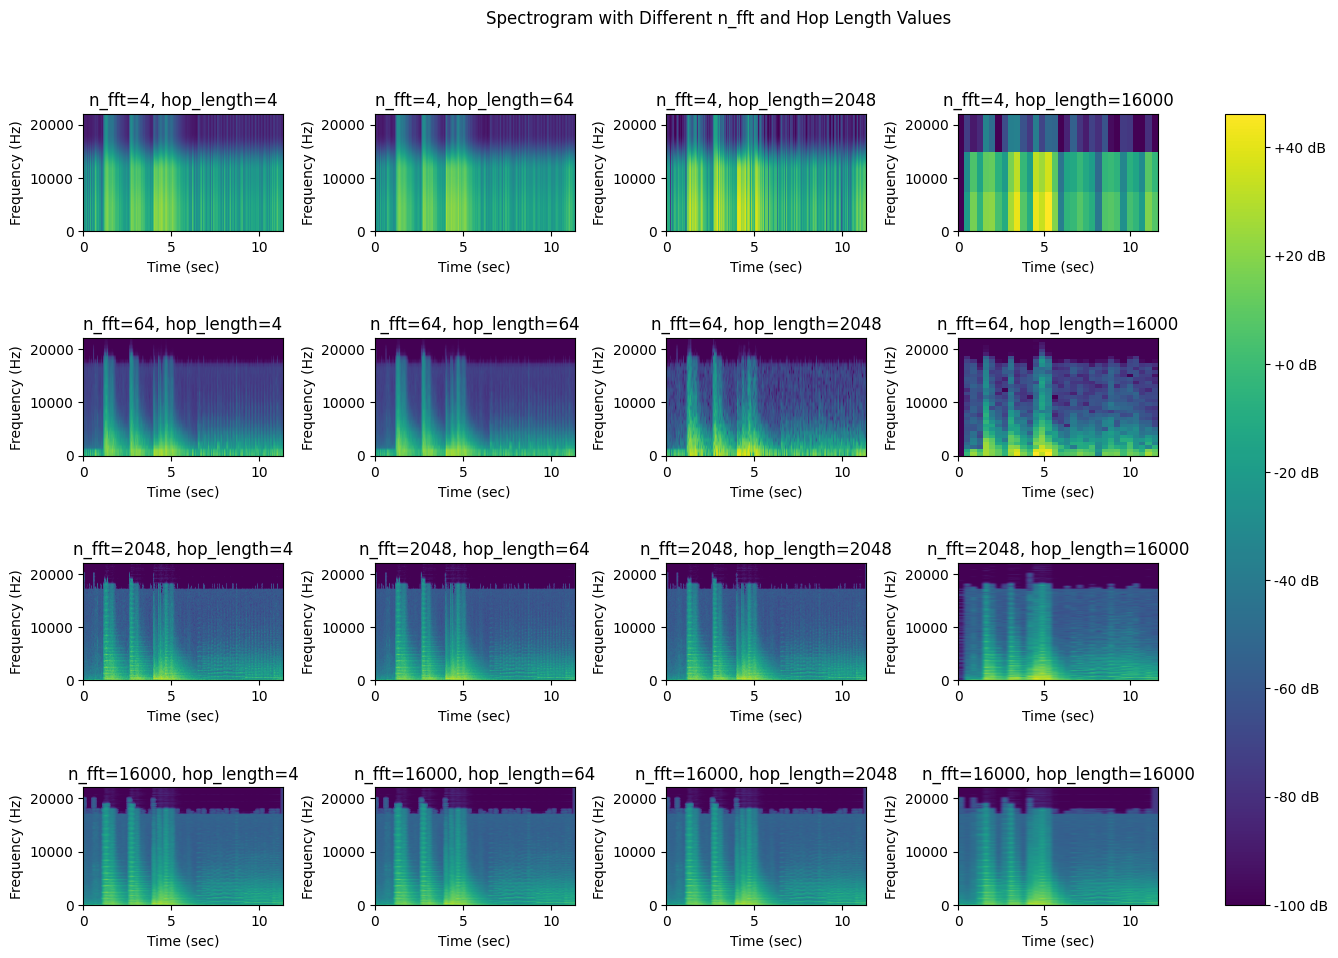

In [7]:
# Parameters for experimentation
n_fft_values = [4, 64, 2048, 16000]  # Different FFT window lengths
hop_length_values = [4, 64,2048, 16000]  # Different hop lengths

# Create subplots
fig, axes = plt.subplots(len(n_fft_values), len(hop_length_values), figsize=(15, 10))

# Ensure the title is set for the entire figure
fig.suptitle('Spectrogram with Different n_fft and Hop Length Values')

for i, n_fft in enumerate(n_fft_values):
    for j, hop_length in enumerate(hop_length_values):
        spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            win_length=n_fft,
            hop_length=hop_length,
        )
        spectrogram = spectrogram_transform(waveform)

        # Convert to dB
        spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

        # Handle single channel data by selecting the first channel if necessary
        if spectrogram_db.dim() == 3:
            spectrogram_db = spectrogram_db[0]

        ax = axes[i][j]  # Get the subplot axis
        img = ax.imshow(spectrogram_db.numpy(), aspect='auto', origin='lower', cmap='viridis',
                        extent=[0, spectrogram_db.size(-1) * hop_length / new_freq,
                                0, new_freq / 2])
        ax.set_title(f'n_fft={n_fft}, hop_length={hop_length}')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')

# Adjust layout to not overlap subplots
plt.tight_layout(pad=3.0)

# Add a colorbar to the figure
fig.colorbar(img, ax=axes.ravel().tolist(), format='%+2.0f dB')

plt.show()


In the provided spectrogram images, we observe the effect of varying the window size (n_fft) and the hop size (hop_length). Here are some observations and the reasoning behind parameter choices:

**Window Size (n_fft):** The window size determines the frequency resolution of the spectrogram. Larger n_fft values provide better frequency resolution because more data points are used to compute the Fourier transform. This is observed in the spectrograms with larger n_fft values, where the frequency bands are more distinct and detailed.
Smaller n_fft values, on the other hand, result in poorer frequency resolution, causing the spectrogram to look more 'smeared' in the frequency dimension. This is evident in the top row of the spectrograms where n_fft is small.

**Hop Size (hop_length):** The hop size dictates the time resolution of the spectrogram. Smaller hop sizes lead to higher time resolution because the audio signal is processed in smaller, more frequent steps. This can be seen when hop_length is smaller, showing finer detail along the time axis.
Larger hop lengths reduce time resolution as they increase the step size between consecutive windows. This causes the features to look stretched out over time, which is noticeable in the spectrograms with larger hop_length values.

**Overlap:** Overlap refers to how much consecutive windows overlap each other, calculated as win_length - hop_length. A higher overlap can lead to more detailed spectrograms but at the cost of increased computational complexity. In the cases where hop_length is much smaller than n_fft, there's a significant overlap, providing more granular detail in time but potentially increasing the spectrogram computation time.


NOTE: We keep n_fft = window_legth so that we dont have to do zero padding or encounter any truncation. 
When choosing n_fft and hop_length, the nature of the audio signal and the specific analysis requirements should be considered: